In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import manifold
%matplotlib inline

In [2]:
#This function uses the sum over the model weights as a count
#it builds the groupby sums column by column, then divides by the total weight of all the answer options
#Then combines all of those together into a dataframe
def getProbDistMatrix(dataFrame, weightingString):
    l=[]
    cols = []
    for c in dataFrame.iloc[:,4:].columns:
        if dataFrame[c].count() > 65:
            a = dataFrame.groupby(c)[weightingString].sum()
            if ' ' in set(a.index):
                a = a.drop(' ')
            l.append(a/a.sum())
            cols.append(c)
    if len(l) > 0:
        df = pd.concat(l,axis=1)
        df.columns = cols
        return df
    else:
        return(pd.DataFrame())

In [3]:
def calcHistogramDistance(dist1, dist2):
    t=np.sqrt(dist1*dist2).sum()
    t=t[t!=0]
    d=np.log(t)*-1
    return d

In [4]:
#read data file into dataframe
df = pd.read_csv(r'C:\Deep Market Analysis\stratvisdata.csv',encoding = 'ISO-8859-1', dtype='str')

In [8]:
#I created a file with labels for each column header in the main data file
cols=pd.read_excel(r'C:\Deep Market Analysis\columnTitles.xlsx')

In [10]:
#drop some of the buisiness use vehicles
dropVehicleList = ['Nissan NV Compact Cargo Van','Nissan NV Passenger Van','Nissan NV Cargo Van']

In [12]:
#list of variables to keep. 
keepList = cols[cols['use'].isin(['Demographics','Make','Model','Segment','weight'])]['n1'].tolist() #excluded 'Question'

In [13]:
keepList

['NR-Combined Weight 2',
 'New Model Purchased (Alpha Order)',
 'New Model Purchased - Brand',
 'New Model Segment',
 'Gender',
 'Marital Status',
 'Lifestage',
 'Lifestage Variable (1)',
 'Lifestage Plus Affluence (1)',
 'Socioeconomic Groups (8)',
 'Generation',
 'Total # Children In Household',
 'Children Under 6',
 'Children 6 To 12',
 'Children 13 To 17',
 'People 18 or Older',
 'Total In Household',
 'Education',
 'Employment FT/PT/Self',
 'Occupation',
 'Total Family Pre-Tax Income',
 'Economic Outlook',
 'Ethnic Group (1)']

In [14]:
#remove unneeded data
modelVar = 'New Model Purchased (Alpha Order)'
weightingString = 'NR-Combined Weight 2'
df2 = df[keepList]
df2 = df2[~df2.loc[:,modelVar].isin(dropVehicleList)]
df2 = df2[~(df2['Children Under 6']=='9')]
df2.loc[:,weightingString] = pd.to_numeric(df2[weightingString])

In [16]:
list(df2.columns)

['NR-Combined Weight 2',
 'New Model Purchased (Alpha Order)',
 'New Model Purchased - Brand',
 'New Model Segment',
 'Gender',
 'Marital Status',
 'Lifestage',
 'Lifestage Variable (1)',
 'Lifestage Plus Affluence (1)',
 'Socioeconomic Groups (8)',
 'Generation',
 'Total # Children In Household',
 'Children Under 6',
 'Children 6 To 12',
 'Children 13 To 17',
 'People 18 or Older',
 'Total In Household',
 'Education',
 'Employment FT/PT/Self',
 'Occupation',
 'Total Family Pre-Tax Income',
 'Economic Outlook',
 'Ethnic Group (1)']

In [17]:
#Creates a probability distribution dict using JD Power segmentation and sales weighting
jdprobDist = {}
jdprobDist['all'] = getProbDistMatrix(df2, weightingString)
sampleCount = {}
sampleCount['all'] = df2.count()
modelKeys = []
segmentKeys = []
makeKeys = []
modelVar = 'New Model Purchased (Alpha Order)'
#create probability distributions for each Series
for model in df2[modelVar].unique():
    temp = df2[df2[modelVar]==model].replace(' ',np.nan)
    if temp[weightingString].count() > 65:
        jdprobDist[model] = getProbDistMatrix(temp, weightingString)
        modelKeys.append(model)
        sampleCount[model] = temp.count()
    else:
        print(model)

jdsegmentVar = 'New Model Segment'
#create probability distributions for each JD Power Segment
for seg in df2[jdsegmentVar].unique():
    temp = df2[df2[jdsegmentVar]==seg].replace(' ',np.nan)
    if temp[weightingString].count() > 65:
        jdprobDist[seg] = getProbDistMatrix(temp, weightingString)
        segmentKeys.append(seg)
        sampleCount[seg] = temp.count()
    else:
        print(seg)

makeVar = 'New Model Purchased - Brand'
#create probability distributions for each Brand
for make in df2[makeVar].unique():
    temp = df2[df2[makeVar]==make].replace(' ',np.nan)
    if temp[weightingString].count() > 65:
        jdprobDist[make] = getProbDistMatrix(temp, weightingString)
        makeKeys.append(make)
        sampleCount[make] = temp.count()
    else:
        print(make)

Ford C-MAX Energi
Subaru BRZ
Acura RLX
Acura RLX Hybrid
Nissan GT-R
Toyota Mirai
Lexus LC
Mitsubishi Lancer
Mercedes-Benz CLS-Class
Mercedes-Benz AMG GT Roadster
Porsche 911 Coupe
Volkswagen Beetle Conv
Audi TT Coupe
Audi A8/S8
Fiat 500e
Alfa Romeo 4C Coupe
Mercedes-Benz G-Class
Porsche Cayenne
Jeep Patriot
Lincoln Navigator L
Chevrolet Express Cargo Van
Infiniti QX70
Chrysler 200 Sdn
Ford Focus Hatchback Electric
Chevrolet Malibu Hybrid
Chevrolet SS
Buick Verano
Cadillac ATS Coupe
Kia Soul EV
Kia Rio Hatchback
Kia K900
Acura NSX
Nissan 370Z Conv
Infiniti Q50 Hybrid Sdn
Toyota 86
Toyota Yaris Hatchback
Mitsubishi Mirage GT Hatchback
Hyundai Accent Hatchback
Hyundai Ioniq EV
Hyundai Sonata Plug-in Hybrid
Hyundai Azera
BMW 7e Series
BMW 5 Series Gran Turismo
BMW 6 Series Coupe
BMW 6 Series Gran Coupe
BMW i8
BMW 6 Series Conv
Jaguar XF Sportbrake
Mercedes-Benz S-Class Maybach
Mercedes-Benz C-Class Plug-in Hybrid
Mercedes-Benz S-Class Coupe
Mercedes-Benz B-Class
Mercedes-Benz AMG GT/GT S
M

In [18]:
#otherwise memory allocation becomes enormous
#for year in yearKeys:
fullDistanceDict = {}
ks = list(jdprobDist.keys())
for i in ks:
    fullDistanceDict[i] = {}
for k1, k2 in combinations(ks,2):
    temp = calcHistogramDistance(jdprobDist[k1],jdprobDist[k2])
    fullDistanceDict[k1][k2] = temp
    fullDistanceDict[k2][k1] = temp

In [19]:
fullDistanceDF = pd.DataFrame.from_dict(fullDistanceDict)

In [20]:
totalDistanceDF = pd.DataFrame(index=fullDistanceDF.index, columns=fullDistanceDF.columns)
for i in tqdm(totalDistanceDF.columns):
    for j in totalDistanceDF.index:
        a = fullDistanceDF.loc[j,i]
        if i==j:
            totalDistanceDF.loc[j,i] = np.nan
        else:
            totalDistanceDF.loc[j,i] = np.sqrt((a*a).sum())

100%|████████████████████████████████████████████████████████████████████████████████| 362/362 [54:43<00:00,  9.07s/it]


In [43]:
df2[df2['New Model Purchased - Brand']=='Infiniti']['New Model Purchased (Alpha Order)'].unique()

array(['Infiniti Q60 Coupe', 'Infiniti Q50 Sdn', 'Infiniti Q70 Sdn',
       'Infiniti QX70', 'Infiniti QX50', 'Infiniti QX60', 'Infiniti QX30',
       'Infiniti QX80', 'Infiniti Q50 Hybrid Sdn'], dtype=object)

In [26]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
result = mds.fit(totalDistanceDF.fillna(0.0))

In [27]:
#vehicleList = ['cluster2','Toyota Avalon','Nissan Maxima','Mid-Size Crossover Utility','Luxury Utility','Large Car','Nissan Rogue Sport','Nissan Versa Note','Nissan Versa Sdn','Infiniti','Honda','Entry Utility','Honda Accord Sdn','Hyundai Santa Fe','Mid-Size Car','Mid-Size Traditional Utility','Mid-Size Crossover Utility','Nissan','Toyota','Chevrolet','Nissan Sentra','Nissan Rogue','Toyota RAV4','Toyota Camry','Toyota Prius', 'Toyota Prius v', 'Toyota Prius Plug-in','Nissan Altima Sdn','Nissan Leaf','Honda Clarity BEV','Honda Clarity Plug-in Hybrid','Honda Accord Hybrid Sdn','Chevrolet Bolt EV','Chevrolet Volt','Acura RLX Hybrid','Lexus ES300 Hybrid','Hyundai Sonata Hybrid','BMW 3 Series Sdn Hybrid','Tesla Model S','Volvo XC90 Hybrid','Acura MDX Hybrid','Nissan Rogue Hybrid','Toyota RAV4 Hybrid','Lexus NX300 Hybrid','Toyota Highlander Hybrid','Ford C-MAX Hybrid', 'Ford Focus Hatchback Electric','Chevrolet Malibu Hybrid','Kia Optima Hybrid','Infiniti Q50 Hybrid Sdn','Toyota Avalon Hybrid','Hyundai Ioniq EV','Mercedes-Benz C-Class Plug-in Hybrid','Volvo S90 Hybrid','Tesla Model 3','Mercedes-Benz GLE e','Chrysler Pacifica Wagon Hybrid','Hyundai Ioniq Plug-in Hybrid','Porsche Cayenne Hybrid','Lexus LS500 Hybrid','Porsche Panamera Hybrid','Lexus GS Hybrid','Mercedes-Benz S-Class Hybrid Sdn']

In [48]:
vehicleList = ['Nissan Maxima','Mid-Size Crossover Utility','Luxury Utility','Large Car','Nissan Rogue Sport','Nissan Versa Note','Nissan Versa Sdn','Infiniti','Entry Utility','Mid-Size Car','Mid-Size Traditional Utility','Mid-Size Crossover Utility','Nissan','Nissan Sentra','Nissan Rogue','Nissan Altima Sdn','Nissan Leaf','Nissan Rogue Hybrid','Infiniti Q50 Sdn','Infiniti QX60','Infiniti QX50','Nissan 370Z Coupe','Nissan Murano','Nissan Pathfinder','Nissan Armada', 'Nissan Frontier','Nissan Titan (LD)', 'Nissan Titan XD', 'Nissan Juke','Nissan 370Z Conv', 'Nissan Kicks','Nissan GT-R','Infiniti Q60 Coupe', 'Infiniti Q50 Sdn', 'Infiniti Q70 Sdn','Infiniti QX70', 'Infiniti QX60', 'Infiniti QX30','Infiniti QX80']

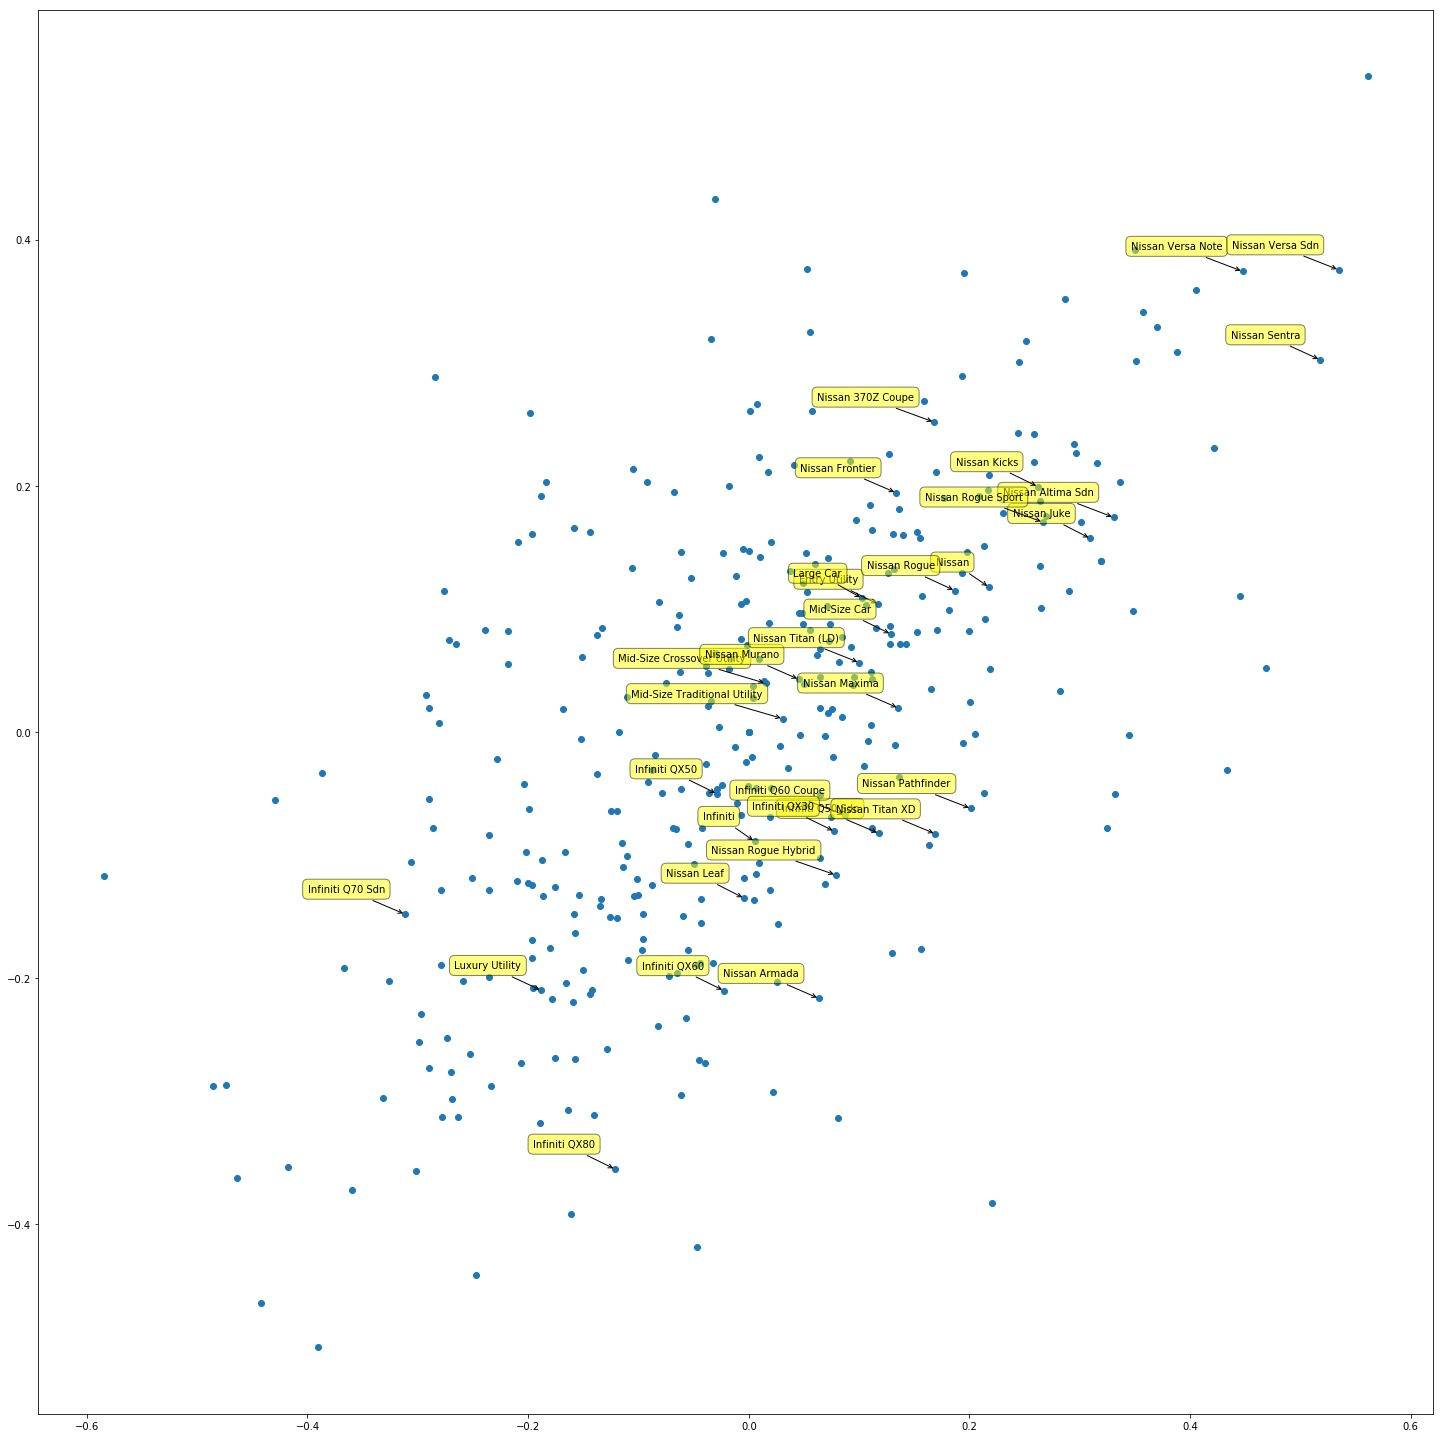

In [49]:
#This is the full 2-D projection of the Demographic dataset distance matrix
coords = result.embedding_
fig = plt.gcf()
plt.subplots_adjust(bottom = 0.1)
#plt.xlim(-.9, .9)
#plt.ylim(-.5, .5)
fig.set_size_inches(25,25)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')
for label, x, y in zip(totalDistanceDF.columns.values, coords[:, 0], coords[:, 1]):
    if label in vehicleList:
        plt.annotate(
            label,
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [50]:
import pickle

In [51]:
#Dump all important demo data files into a file
pickle.dump( [totalDistanceDF,fullDistanceDF,jdprobDist2] , open( "histDistStratVis05212019.p", "wb" ) )

In [ ]:
#Load all important demo data from file
totalDistanceDF,fullDistanceDF,jdprobDist2 = pickle.load(open( "histDistStratVis05212019.p", "rb" ))

In [ ]:
df2.head()

In [ ]:
totalDistanceDF.columns.values

In [ ]:
pd.concat([pd.Series(totalDistanceDF.columns.values), pd.Series(coords[:, 0]), pd.Series(coords[:, 1])],axis=1).to_excel(r'D:\Strat Vis 2D Data.xlsx')

In [ ]:
#shows vehicle distance from overall dataset
distance.drop('all').sort_values(ascending=False).plot(kind='bar', figsize=(20,8))

In [ ]:
df1[jdsegmentVar].unique()

In [ ]:
distance[vehicleList].dropna().sort_values(ascending=False).plot(kind='bar', figsize=(20,8))

In [ ]:
df['OVERALL Exterior Styling']

In [ ]:
jdprobDist['all']

In [ ]:
segmentDist = {}
distBySegment = {}
setOfKeys = set(jdprobDist.keys())
for segment in df[jdsegmentVar].unique():
    distBySegment[segment] = {}
    for model in df[df[jdsegmentVar]==segment][modelVar].unique():
        if model in setOfKeys:
            a = np.sqrt(jdprobDist[model].fillna(0)*jdprobDist[segment].fillna(0)).sum()
            a=a[a!=0]
            a=-1*np.log(a)
            b = pd.concat([a,sampleCount[model]],axis=1)
            b = b[b[1]>50]
            c = b[0].rename('Segment Distance')
            segmentDist[model] = c
            distBySegment[segment][model] = c
        else:
            print(model)

In [ ]:
a = pd.DataFrame(distBySegment['Mid-Size Car'])
np.sqrt((a*a).sum()).sort_values(ascending=False).plot(kind='bar', title='Midsizer Car Distance to Segment for all variables', figsize=(15,6))

In [ ]:
distance['Nissan Altima Sdn'].dropna().sort_values(ascending=False).iloc[:30].plot(kind='bar', rot=90,title='Subaru Legacy Variable Distance to Segment', figsize=(15,6))

In [ ]:
a = pd.DataFrame(segmentDist)
a = a.fillna(0)
segmentDistance = np.sqrt((a*a).sum())
segmentDistance.sort_values(ascending=False).plot(kind='bar', figsize=(20,8))

In [ ]:
makeDist = {}
distByMake = {}
setOfKeys = set(jdprobDist.keys())
for make in df[makeVar].unique():
    distByMake[make] = {}
    for model in df1[df1[makeVar]==make][modelVar].unique():
        if model in setOfKeys:
            a = np.sqrt(jdprobDist[model].fillna(0)*jdprobDist[make].fillna(0)).sum()
            a=a[a!=0]
            a=-1*np.log(a)
            b = pd.concat([a,sampleCount[model]],axis=1)
            b = b[b[1]>50]
            c = b[0].rename('Make Distance')
            makeDist[model] = c
            distByMake[make][model]=c
        else:
            print(model)

In [ ]:
a = pd.DataFrame(distByMake['Nissan'])
np.sqrt((a*a).sum()).sort_values(ascending=False).plot(kind='bar', title='Nissan Distance to Brand for All Variables', figsize=(15,6))

In [ ]:
segmentDist['Tesla Model 3'].dropna().sort_values(ascending=False).iloc[:40].plot(kind='bar', rot=90,title='Nissan Titan Variable Distance to Segment', figsize=(15,6))

In [ ]:
segmentDist['Tesla Model 3'].dropna().sort_values(ascending=False).iloc[:40].plot(kind='bar', rot=90,title='Nissan Titan Variable Distance to Segment', figsize=(15,6))

In [ ]:
a = pd.DataFrame(makeDist)
a = a.fillna(0)
makeDistance = np.sqrt((a*a).sum())
makeDistance.sort_values(ascending=False).plot(kind='bar', figsize=(20,8))

In [ ]:
makeSegDistance = pd.concat([makeDistance, segmentDistance],axis=1)
makeSegDistance.columns=['Make Distance','Segment Distance']

In [ ]:
vehicleList = ['Toyota Prius', 'Toyota Prius v', 'Toyota Prius Plug-in','Nissan Altima Sdn','Nissan Leaf','Honda Clarity BEV','Honda Clarity Plug-in Hybrid','Honda Accord Hybrid Sdn','Chevrolet Bolt EV','Chevrolet Volt','Acura RLX Hybrid','Lexus ES300 Hybrid','Hyundai Sonata Hybrid','BMW 3 Series Sdn Hybrid','Tesla Model S','Volvo XC90 Hybrid','Acura MDX Hybrid','Nissan Rogue Hybrid','Toyota RAV4 Hybrid','Lexus NX300 Hybrid','Toyota Highlander Hybrid','Ford C-MAX Hybrid', 'Ford Focus Hatchback Electric','Chevrolet Malibu Hybrid','Kia Optima Hybrid','Infiniti Q50 Hybrid Sdn','Toyota Avalon Hybrid','Hyundai Ioniq EV','Mercedes-Benz C-Class Plug-in Hybrid','Volvo S90 Hybrid','Tesla Model 3','Mercedes-Benz GLE e','Chrysler Pacifica Wagon Hybrid','Hyundai Ioniq Plug-in Hybrid','Porsche Cayenne Hybrid','Lexus LS500 Hybrid','Porsche Panamera Hybrid','Lexus GS Hybrid','Mercedes-Benz S-Class Hybrid Sdn']

In [ ]:
df1['New Model Purchased (Alpha Order)'].unique()

In [ ]:
makeSegDistance.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
#axes.set_xlim([0,.5])
#axes.set_ylim([0,.5])
for txt in list(makeSegDistance.index.values):
    if txt in vehicleList:
        if np.sqrt((makeSegDistance.loc[txt,'Segment Distance']*makeSegDistance.loc[txt,'Segment Distance'])+(makeSegDistance.loc[txt,'Make Distance']*makeSegDistance.loc[txt,'Make Distance']))>0.0:
            plt.annotate(txt, (makeSegDistance.loc[txt,'Make Distance'],makeSegDistance.loc[txt,'Segment Distance']))

In [ ]:
vehicle = 'Nissan Rogue'
temp = pd.concat([makeDist[vehicle],segmentDist[vehicle]],axis=1)
temp.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
#axes.set_xlim([0,.5])
#axes.set_ylim([0,.5])
for txt in list(temp.index.values):
    if np.sqrt((temp.loc[txt,'Segment Distance']*temp.loc[txt,'Segment Distance'])+(temp.loc[txt,'Make Distance']*temp.loc[txt,'Make Distance']))>0.005:
        plt.annotate(txt, (temp.loc[txt,'Make Distance'],temp.loc[txt,'Segment Distance']))

In [ ]:
temp.plot(kind='scatter',x='Make Distance',y='Segment Distance')

In [ ]:
demographicVars = set(['Gender','Marital Status','Lifestage','Lifestage Variable (1)','Lifestage Plus Affluence (1)','Customer Type','Socioeconomic Groups (8)','Age Bracket','Age Bucket','Total Children In Household','Children Under 6','Children 6 To 12','Children 13 To 17','People 18 or Older','Total In Household','Education','Employment FT/PT/Self','Total Family Pre-Tax Income','Economic Outlook','Ethnic Group (1)','Location Of Residence','Customer Region Classification'])
otherVars = set(['Brand (Disposed)', 'Corporation (disposed)', 'Origin (Disposed)', 'Most Important Purchase Reason (2014/2016 Version)', 'Rzns Didn\'t Buy Model Most Seriously Considered (Mk) (1)', 'Most Important Reason Didn\'t Buy Model Most Seriously Considered', 'Occupation', 'State'])

In [ ]:
noDemoMakeDist = {}
for k, v in makeDist.items():
    noDemoMakeDist[k] = v.drop(set(v.dropna().index).intersection(demographicVars.union(otherVars))).dropna()

In [ ]:
noDemoSegmentDist = {}
for k, v in segmentDist.items():
    noDemoSegmentDist[k] = v.drop(set(v.dropna().index).intersection(demographicVars.union(otherVars))).dropna()

In [ ]:
a = pd.DataFrame(noDemoMakeDist)
a = a.fillna(0)
noDemoMakeDistance = np.sqrt((a*a).sum())

a = pd.DataFrame(noDemoSegmentDist)
a = a.fillna(0)
noDemoSegmentDistance = np.sqrt((a*a).sum())

noDemoMakeSegDistance = pd.concat([noDemoMakeDistance, noDemoSegmentDistance],axis=1)
noDemoMakeSegDistance.columns=['Make Distance','Segment Distance']

In [ ]:
noDemoMakeSegDistance.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
#axes.set_xlim([0,.5])
#axes.set_ylim([0,.5])
for txt in list(noDemoMakeSegDistance.index.values):
    if np.sqrt((noDemoMakeSegDistance.loc[txt,'Segment Distance']*noDemoMakeSegDistance.loc[txt,'Segment Distance'])+(noDemoMakeSegDistance.loc[txt,'Make Distance']*noDemoMakeSegDistance.loc[txt,'Make Distance']))>0.0:
        plt.annotate(txt, (noDemoMakeSegDistance.loc[txt,'Make Distance'],noDemoMakeSegDistance.loc[txt,'Segment Distance']))

In [ ]:
vehicle = 'Nissan Altima Sdn'
temp = pd.concat([noDemoMakeDist[vehicle],noDemoSegmentDist[vehicle]],axis=1)
temp.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
#axes.set_xlim([0,.5])
#axes.set_ylim([0,.5])
for txt in list(temp.index.values):
    if np.sqrt((temp.loc[txt,'Segment Distance']*temp.loc[txt,'Segment Distance'])+(temp.loc[txt,'Make Distance']*temp.loc[txt,'Make Distance']))>0.01:
        plt.annotate(txt, (temp.loc[txt,'Make Distance'],temp.loc[txt,'Segment Distance']))

In [ ]:
demoMakeDist = {}
for k, v in makeDist.items():
    demoMakeDist[k] = v.loc[set(v.index).intersection(demographicVars)]

demoSegmentDist = {}
for k, v in segmentDist.items():
    demoSegmentDist[k] = v.loc[set(v.index).intersection(demographicVars)]

In [ ]:
a = pd.DataFrame(demoMakeDist)
a = a.fillna(0)
demoMakeDistance = np.sqrt((a*a).sum())

a = pd.DataFrame(demoSegmentDist)
a = a.fillna(0)
demoSegmentDistance = np.sqrt((a*a).sum())

demoMakeSegDistance = pd.concat([demoMakeDistance, demoSegmentDistance],axis=1)
demoMakeSegDistance.columns=['Make Distance','Segment Distance']

In [ ]:
demoMakeSegDistance.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
#axes.set_xlim([0,.5])
#axes.set_ylim([0,.5])
for txt in list(demoMakeSegDistance.index.values):
    if np.sqrt((demoMakeSegDistance.loc[txt,'Segment Distance']*demoMakeSegDistance.loc[txt,'Segment Distance'])+(demoMakeSegDistance.loc[txt,'Make Distance']*demoMakeSegDistance.loc[txt,'Make Distance']))>0.0:
        plt.annotate(txt, (demoMakeSegDistance.loc[txt,'Make Distance'],demoMakeSegDistance.loc[txt,'Segment Distance']))

In [ ]:
vehicle = 'Nissan Titan'
temp = pd.concat([demoMakeDist[vehicle],demoSegmentDist[vehicle]],axis=1)
temp.plot(kind='scatter',x='Make Distance',y='Segment Distance')
axes = plt.gca()
axes.set_xlim([0,.15])
axes.set_ylim([0,.15])
for txt in list(temp.index.values):
    if np.sqrt((temp.loc[txt,'Segment Distance']*temp.loc[txt,'Segment Distance'])+(temp.loc[txt,'Make Distance']*temp.loc[txt,'Make Distance']))>0.001:
        plt.annotate(txt, (temp.loc[txt,'Make Distance'],temp.loc[txt,'Segment Distance']))

In [ ]:
consistentScoreVars = ['Im Curious and Open to Experiences','Luxury is Not Important Unless it Has Purpose','Driving is one of my favorite things to do','When I drive for fun, I mainly prefer to relax and listen to music or talk','I want vehicles that provide that open-air driving experience','I prefer a vehicle that has the capability to outperform others','I prefer vehicles that provide superior acceleration','I prefer vehicles that provide superior handling and cornering agility','I prefer a balance of comfort and performance','I prefer vehicles that provide the softest, most comfortable ride quality','I just want the basics on my vehicle - no extras','I prefer vehicles that project a tough, workman-like image','Vehicles are a tool or a part of the gear in an active outdoors lifestyle','I want to be able to tow heavy loads','I want to be able to traverse any terrain','I make all large vehicle decisions with my familys best interest in mind','My vehicle gives me a feeling of adventure','My vehicle is my sanctuary','Fuel economy is a leading consideration in my purchase decision','I want a basic, no-frills vehicle that does the job','I see my vehicle as an extension of my personality','Price is most important to me when buying a new vehicle','I will easily switch brands for price or features','There are lots of different brands of vehicles that I would consider buying','I want a vehicle that provides the quietest interior','I want to look good when driving my vehicle','I want my vehicle to stand out in a crowd','I want the most versatility in my interior','I would pay significantly more for environmentally friendly vehicle','My vehicle is a reflection of my achievement','I chose my vehicle to reward myself for my hard work','The brand of vehicle I buy makes a statement about who I am','Overall Exterior Styling','Appearance of Wheels & Rims','Appearance of Tires','Headlight Design','Overall Exterior Workmanship','Sound of Doors/Trunk/Hatch Shutting','Overall Driving Performance','Fun To Drive','Ground Clearance','Riding Comfort','Maneuverability','Road Holding Ability','Handling','Overall Power and Pickup','Acceleration From Stop','Passing Capability','Overall Interior Styling','Interior Colors','Overall Interior Workmanship','Quality of Interior Materials','Instrument Panel','Overall Interior Design','Ease of Front Seat Entry','Front Seat Roominess','Passenger Seating Capacity','Interior Storage','Interior Roominess','Cargo Capacity','Haul Cargo in Bed','Cupholders','Ease of Loading/Unloading Cargo','Comfort of Front Seat','Driver Seat Adjustability','Driver Armrests','Seating Versatility/Stowaway','Overall Performance of Sound System','Overall Quietness','CVT','Smoothness of Transmission','Overall Impression of Durability/Reliability','Overall Safety of the Vehicle','Overall Thoughtful Engineering','Placement/Ease of Reading and Using Controls','Electronic Displays of Information','Usefulness of Trunk/Cargo Area','Flat Tire Preparedness (spare, run-flat, etc.)','Safety Features','Front Visibility','Rear Visibility','Braking','Overall Value for the Money','Price/Deal Offered','Future Trade-In or Resale Value','Warranty Coverage','Technical Innovations','Level of Standard Equipment','Fuel Economy/Mileage','Affordable to Buy','Overall Environmental Friendliness','Overall Brand Image','Reputation/Prestige of Manufacturer','Past Experience With Brand','Dealer Location','Dealer Reputation','Overall Experience with Selling Dealership','Overall Experience with Service Department','Advertising/Promotion','Advice of Friends/Relatives','Magazine/Newspaper/TV Reviews','Overall Seat Comfort','Overall Interior Versatility','Overall Image of the Vehicle','4WD/AWD Availability','Navigation System','Discount/Rebate/Incentive','Towing Capability','Interest Rate, Credit Terms','Leasing Terms','Audiovisual System','Ease Of Customizing','Engine Performance','Connectivity (WiFi, Bluetooth, etc.)','Interactive Information System (OnStar, mbrace, iDrive, etc.)','Driving Distance on Full Tank/Charge']

In [ ]:
df1[consistentScoreVars]=df1[consistentScoreVars].replace(to_replace=' ',value=np.nan)

In [ ]:
df1[consistentScoreVars] = df1[consistentScoreVars].apply(pd.to_numeric)

In [ ]:
consistentScoreDF = df1[['Sales Weighting']+[makeVar]+[modelVar]+[jdsegmentVar]+consistentScoreVars]

In [ ]:
selfScoreDict={}
#vehicle = 'Nissan Altima Sdn'
for vehicle in consistentScoreDF[modelVar].unique():
    #get variable counts
    countMatrix=consistentScoreDF[consistentScoreDF[modelVar]==vehicle].iloc[:,4:].apply(pd.value_counts)
    #prune variables with small sample sizes
    truncatedCountMatrix = countMatrix.loc[:,countMatrix.sum()>50]
    if len(truncatedCountMatrix.columns)==0:
        continue
    total=truncatedCountMatrix.sum(axis=1)
    #calculate vehicle overall question probability distribution
    totalQ=total/total.sum()
    #calculate each question's probability distribution
    probDistQ = truncatedCountMatrix/truncatedCountMatrix.sum()
    #calculate each question's distance to vehicle question distribution
    distQ = -1*np.log(np.sqrt(probDistQ.T*totalQ).sum(axis=1))
    #calculate each question mean
    scores=consistentScoreDF[consistentScoreDF[modelVar]==vehicle][truncatedCountMatrix.columns].mean()
    #combine question self-distance and mean into single dataframe
    scoreQ = pd.concat([distQ,scores],axis=1)
    scoreQ.columns=['Self-Average Question Distance','Average Score']
    #insert into dict keyed on vehicle
    selfScoreDict[vehicle]=scoreQ

In [ ]:
vehicle = 'Nissan Altima Sdn'
scoreQ = selfScoreDict[vehicle].dropna()
scoreQ.plot(kind='scatter',x='Average Score',y='Self-Average Question Distance', title='Nissan Titan Question Self-Distance vs Score', figsize=(12,8))
for txt in list(scoreQ.index.values):
    if scoreQ.loc[txt,'Self-Average Question Distance']>.04:
        plt.annotate(txt, (scoreQ.loc[txt,'Average Score'],scoreQ.loc[txt,'Self-Average Question Distance']))

In [ ]:
consistentScoreDF[consistentScoreDF[modelVar]==vehicle].iloc[:,4:].apply(pd.value_counts)['Engine Performance'].plot(kind='bar', title='Nissan Titan Engine Performance Counts')

In [ ]:
countMatrix=consistentScoreDF[consistentScoreDF[modelVar]==vehicle].iloc[:,4:].apply(pd.value_counts)
total=countMatrix.sum(axis=1)
total.plot(kind='bar', title='Nissan Titan Average Score Counts')

In [ ]:
scoreQAllDict = {}
for k, v in selfScoreDict.items():
    totalDist = v['Self-Average Question Distance']
    totalDist = np.sqrt((totalDist*totalDist).sum())
    avgScore = v['Average Score'].mean()
    scoreQAllDict[k] = (totalDist,avgScore)

In [ ]:
scoreQAll = pd.DataFrame(scoreQAllDict).T
scoreQAll.columns = ['Self-Average Question Distance','Average Score']

In [ ]:
scoreQAll.plot(kind='scatter',x='Average Score',y='Self-Average Question Distance', title='All Models Self-Distance vs Score', figsize=(12,8))
for txt in list(scoreQAll.index.values):
    if scoreQAll.loc[txt,'Self-Average Question Distance']>0.0:
        plt.annotate(txt, (scoreQAll.loc[txt,'Average Score'],scoreQAll.loc[txt,'Self-Average Question Distance']))

In [ ]:
#calculate segment score averages, taking into account weighting
segmentScores = {}
for segment in consistentScoreDF[jdsegmentVar].unique():
    print(segment)
    a=consistentScoreDF[consistentScoreDF[jdsegmentVar]==segment]
    dfc = pd.DataFrame()
    for c in consistentScoreDF.iloc[:,4:].columns:
        dfc[c] = a.loc[:,c]*a.loc[:,'Sales Weighting']
    segmentScores[segment] = dfc.sum()/a.loc[:,'Sales Weighting'].sum()

In [ ]:
segmentScoreDict={}
#vehicle = 'Nissan Altima Sdn'
for vehicle in consistentScoreDF[modelVar].unique():
    #get vehicle's segment
    data = consistentScoreDF[consistentScoreDF[modelVar]==vehicle]
    segment=data.loc[:,jdsegmentVar].iloc[0]
    temp = consistentScoreDF[consistentScoreDF[jdsegmentVar]==segment].iloc[:,4:].apply(pd.value_counts)
    segmentDist = temp/temp.sum()
    
    #get variable counts
    countMatrix=data.iloc[:,4:].apply(pd.value_counts)
    #prune variables with small sample sizes
    truncatedCountMatrix = countMatrix.loc[:,countMatrix.sum()>65]
    if len(truncatedCountMatrix.columns)==0:
        print(vehicle)
        continue

    #calculate each question's probability distribution
    probDistQ = truncatedCountMatrix/truncatedCountMatrix.sum().fillna(0)
    #calculate each question's distance to segment question distribution
    distQ = -1*np.log(np.sqrt(probDistQ*segmentDist).sum())
    #calculate each question mean
    l=segmentScores[segment]
    modelScores=data[truncatedCountMatrix.columns].mean()-l
    #calculate difference between model scores and segment scores
    
    #combine question self-distance and mean into single dataframe
    scoreQ = pd.concat([distQ,modelScores],axis=1)
    scoreQ.columns=['Question Distance to Segment','Segment Score Delta']
    #insert into dict keyed on vehicle
    segmentScoreDict[vehicle]=scoreQ

In [ ]:
scoreSegmentAllDict = {}
scoreSegmentByModel = {}
for s in consistentScoreDF[jdsegmentVar].unique():
    scoreSegmentByModel[s] = {}

for k, v in segmentScoreDict.items():
    segment = consistentScoreDF[consistentScoreDF[modelVar]==k].loc[:,jdsegmentVar].iloc[0]
    totalDist = v['Question Distance to Segment']
    totalDist = np.sqrt((totalDist*totalDist).sum())
    avgScore = v['Segment Score Delta'].mean()
    scoreSegmentAllDict[k] = (totalDist,avgScore)
    scoreSegmentByModel[segment][k] = (totalDist,avgScore)
    
scoreSegmentAll = pd.DataFrame(scoreSegmentAllDict).T
scoreSegmentAll.columns = ['Question Distance to Segment','Segment Score Delta']

In [ ]:
scoreSegmentAll.plot(kind='scatter',x='Segment Score Delta',y='Question Distance to Segment', figsize=(20,15))
plt.title("")
for txt in list(scoreSegmentAll.index.values):
    if scoreSegmentAll.loc[txt,'Question Distance to Segment']>0.00:
        plt.annotate(txt, (scoreSegmentAll.loc[txt,'Segment Score Delta'],scoreSegmentAll.loc[txt,'Question Distance to Segment']))

In [ ]:
a=pd.DataFrame(scoreSegmentByModel['Large Light Duty Pickup'])
a.index = ['Question Distance to Segment','Segment Score Delta']
a=a.T
a.plot(kind='scatter',x='Segment Score Delta',y='Question Distance to Segment', title='Light Duty Pickup Distance to Segment vs Score Delta', figsize=(10,8))
for txt in list(a.index.values):
    plt.annotate(txt, (a.loc[txt,'Segment Score Delta'],a.loc[txt,'Question Distance to Segment']))

In [ ]:
vehicle = 'Nissan Titan'
scoreQ = segmentScoreDict[vehicle].dropna()
scoreQ.plot(kind='scatter',x='Segment Score Delta',y='Question Distance to Segment', title='Distance to Segment vs Segment Score Delta', figsize=(20,15))
for txt in list(scoreQ.index.values):
    if scoreQ.loc[txt,'Question Distance to Segment']>.004:
        plt.annotate(txt, (scoreQ.loc[txt,'Segment Score Delta'],scoreQ.loc[txt,'Question Distance to Segment']))

In [ ]:
var = 'I see my vehicle as an extension of my personality'
consistentScoreDF[consistentScoreDF[modelVar]==vehicle].iloc[:,4:].apply(pd.value_counts)[var].plot(kind='bar', title='Nissan Titan score counts for \"'+var+'\"')

In [ ]:
segment=consistentScoreDF[consistentScoreDF[modelVar]==vehicle].loc[:,jdsegmentVar].iloc[0]
pd.value_counts(consistentScoreDF[consistentScoreDF[jdsegmentVar]==segment][var]).sort_index().plot(kind='bar',title='Light-Duty Pickup Segment score counts for \"'+var+'\"')

In [ ]:
a=consistentScoreDF[consistentScoreDF[modelVar]==vehicle].iloc[:,4:].apply(pd.value_counts)[var]
a/a.sum()

In [ ]:
b=countMatrix=pd.value_counts(consistentScoreDF[consistentScoreDF[jdsegmentVar]==segment][var])
b/b.sum()

In [ ]:
var = ['I want a basic, no-frills vehicle that does the job']
consistentScoreDF[consistentScoreDF[jdsegmentVar]=='Large Light Duty Pickup'].hist(bins=range(1,6), figsize=(9, 6))
plt.tight_layout()

In [ ]:
var = [modelVar, jdsegmentVar,'I want a basic, no-frills vehicle that does the job']
consistentScoreDF[consistentScoreDF[jdsegmentVar]=='Large Light Duty Pickup'][var].hist(by=modelVar,bins=range(1,6), figsize=(18, 12))
plt.tight_layout()

In [ ]:
consistentScoreDF[consistentScoreDF[modelVar]=='Nissan Titan'].iloc[:,10:16].hist(bins=range(1,6), figsize=(18, 12))
plt.tight_layout()

In [ ]:
df1[df1[jdsegmentVar]=='Midsize Car'].groupby([modelVar,'State'])['Sales Weighting'].count().unstack().to_excel('daata.xlsx')

In [ ]:
l={}
names = []
k = set(jdprobDist.keys())
for m in df1[df1[jdsegmentVar]=='Midsize Car'][modelVar].unique():
    if m in k:
        a = np.sqrt(jdprobDist[m].fillna(0)*jdprobDist['Midsize Car'].fillna(0)).sum()
        a=a[a!=0]
        a=-1*np.log(a)
        l[m]=a

In [ ]:
p={}
for k,v in l.items():
    p[k]=v['State']

In [ ]:
pd.Series(p).plot(kind='bar', title='Midsize Car Residence Distances')

THIS IS WHERE THE DEEP MARKET ANALYSIS SPECIFIC TO A CLUSTER BEGINS

In [ ]:
dfEV = pd.read_excel(r'C:\Users\peterk2\Desktop\Deep Market Analysis\AllClusteredData.xlsx', sheet_name='Sheet1', dtype='str')

In [ ]:
dfEV2 = dfEV[dfEV['Cluster']=='2'].drop('Cluster',axis=1)

In [ ]:
dfEV2

In [ ]:
df2.columns

In [ ]:
def totChil(row):
    if row['Total # Children In Household']=='0-None':
        return '0'

    return '1'

In [ ]:
df2['Have Children'] = df2.apply(totChil, axis=1)

In [ ]:
df2 = df2.drop('Total # Children In Household',axis=1)

In [ ]:
def yChil(row):
    if row['Children Under 6']=='0-None':
        return '0'

    return '1'

In [ ]:
df2['Children Under 6'] = df2.apply(yChil, axis=1)

In [ ]:
def mChil(row):
    if row['Children 6 To 12']=='0-None':
        return '0'

    return '1'

In [ ]:
df2['Children 6 To 12'] = df2.apply(mChil, axis=1)

In [ ]:
def lChil(row):
    if row['Children 13 To 17']=='0-None':
        return '0'

    return '1'

In [ ]:
df2['Children 13 To 17'] = df2.apply(lChil, axis=1)

In [ ]:
def eChil(row):
    if row['People 18 or Older']=='0-None':
        return '0'

    return '1'

In [ ]:
df2['People 18 or Older'] = df2.apply(eChil, axis=1)

In [ ]:
dfEV2.loc[:,weightingString] = pd.to_numeric(dfEV2[weightingString])
dfEV2 = dfEV2[df2.columns]

In [ ]:
temp = dfEV2.replace(' ',np.nan)
jdprobDist['cluster2'] = getProbDistMatrix(temp, weightingString)
jdprobDist['cluster2'] = jdprobDist['cluster2'][jdprobDist['all'].columns.tolist()]

In [ ]:
jdprobDist['all']['Lifestage Variable (1)'].dropna()

In [ ]:
totalDistanceDF['all']

In [ ]:
fullDistanceDF['cluster2']['all']

In [ ]:
fullDistanceDF['Nissan Altima Sdn']['all']

In [ ]:
list(jdprobDist.keys())

In [ ]:
replaceDict = {'9.5 : I Love It':9.5,'7.5 : Delightful':7.5,'5.5 : Excellent':5.5,'3.5 : Satisfactory':3.5,'1.5 : A Failure':1.5}